<a href="https://colab.research.google.com/github/eliud2108/Vision_IA/blob/main/SWINIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from google.colab import drive
import torch
import torchvision.transforms as transforms
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:

img_path = '/content/drive/MyDrive/VISION_con_IA/G_4_Apre_prof/Img_TAC'
output_path = os.path.join(img_path, 'resultados')
os.makedirs(output_path, exist_ok=True)

In [ ]:
# Obtener la lista de imágenes
img_files = sorted(glob(os.path.join(img_path, '*.png')) +
                  glob(os.path.join(img_path, '*.jpg')) +
                  glob(os.path.join(img_path, '*.jpeg')))

print(f"Se encontraron {len(img_files)} imágenes en la ruta especificada.")

Se encontraron 4 imágenes en la ruta especificada.


In [ ]:
# Función para calcular ENL (Equivalent Number of Looks)
def calculate_enl(img):
    """
    Calcula el ENL (Equivalent Number of Looks) de una imagen.
    ENL = mean^2 / variance
    Un valor más alto indica menos speckle noise.
    """
    mean = np.mean(img)
    variance = np.var(img)
    if variance == 0:
        return float('inf')  # Para evitar división por cero
    return (mean**2) / variance

In [ ]:
# Función para aplicar SwinIR si está disponible o usar otro modelo
def apply_restoration(img):
    """
    Aplica un modelo de restauración a la imagen.
    Si SwinIR no está disponible, usamos otro método.
    """
    try:
        # Intentamos usar SwinIR si está disponible
        if 'swinir' not in globals():
            # Instalamos SwinIR si no está disponible
            print("Instalando SwinIR y dependencias...")
            !pip install -q timm
            !git clone https://github.com/JingyunLiang/SwinIR.git

            import sys
            sys.path.append('./SwinIR')
            from SwinIR.main_test_swinir import define_model, test

            global swinir
            swinir = True

            # Descargamos un modelo preentrenado para restauración de imágenes
            !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P ./SwinIR/experiments/pretrained_models

            # Definimos el modelo
            model_path = './SwinIR/experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth'
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = define_model(task='real_sr', scale=1, training_patch_size=64,
                                 model_path=model_path, device=device)
            model.eval()

        # Convertimos la imagen a PIL y luego a tensor
        img_pil = Image.fromarray(np.uint8(img))
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)

        # Convertimos de tensor a numpy
        output = output.squeeze().float().cpu().clamp_(0, 1).numpy()
        output = np.transpose(output, (1, 2, 0))
        if output.shape[2] == 1:  # Si es una imagen en escala de grises
            output = np.squeeze(output, axis=2)

        restored_img = np.uint8(output * 255.0)

        print("Imagen restaurada con SwinIR.")
        return restored_img

    except Exception as e:
        print(f"No se pudo usar SwinIR: {e}")
        print("Usando método alternativo de restauración...")

        # Método alternativo: BM3D o filtros clásicos
        try:
            # Intentamos usar BM3D
            !pip install -q bm3d
            import bm3d
            sigma_est = np.mean(estimate_noise(img))
            restored_img = bm3d.bm3d(img, sigma_psd=sigma_est)
            restored_img = np.uint8(np.clip(restored_img, 0, 255))
            print("Imagen restaurada con BM3D.")
            return restored_img
        except:
            # Si BM3D falla, usamos filtros clásicos
            # Convertimos a escala de grises si es necesario
            if len(img.shape) > 2 and img.shape[2] > 1:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img

            # Usamos un filtro de reducción de ruido
            restored_img = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

            # Mejoramos el contraste
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            restored_img = clahe.apply(restored_img)

            print("Imagen restaurada con métodos clásicos de OpenCV.")
            return restored_img

In [ ]:
 #Función para estimar el ruido en una imagen
def estimate_noise(img):
    """
    Estima el nivel de ruido en una imagen usando la desviación estándar
    en regiones homogéneas.
    """
    # Convertimos a escala de grises si es necesario
    if len(img.shape) > 2:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img.copy()

    # Aplicamos el operador Laplaciano
    noise = cv2.Laplacian(img_gray, cv2.CV_64F)

    # Calculamos la desviación estándar
    return np.std(noise)

# Función para evaluar las métricas entre la imagen original y la restaurada
def evaluate_metrics(original, restored):
    """
    Calcula las métricas de calidad entre la imagen original y la restaurada.
    """
    # Convertimos a escala de grises si es necesario
    if len(original.shape) > 2 and original.shape[2] > 1:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original

    if len(restored.shape) > 2 and restored.shape[2] > 1:
        restored_gray = cv2.cvtColor(restored, cv2.COLOR_BGR2GRAY)
    else:
        restored_gray = restored

    # Aseguramos que las imágenes tengan el mismo tamaño
    if original_gray.shape != restored_gray.shape:
        restored_gray = cv2.resize(restored_gray, (original_gray.shape[1], original_gray.shape[0]))

    # Calculamos las métricas
    ssim_value = ssim(original_gray, restored_gray)
    psnr_value = psnr(original_gray, restored_gray)
    enl_original = calculate_enl(original_gray)
    enl_restored = calculate_enl(restored_gray)

    return {
        'SSIM': ssim_value,
        'PSNR': psnr_value,
        'ENL_original': enl_original,
        'ENL_restored': enl_restored,
        'ENL_improvement': enl_restored / enl_original if enl_original > 0 else float('inf')
    }


Procesando imagen 1/4: arteriografia-cerebral-lesion-lobular.jpg
No se pudo usar SwinIR: cannot access local variable 'device' where it is not associated with a value
Usando método alternativo de restauración...
Imagen restaurada con BM3D.


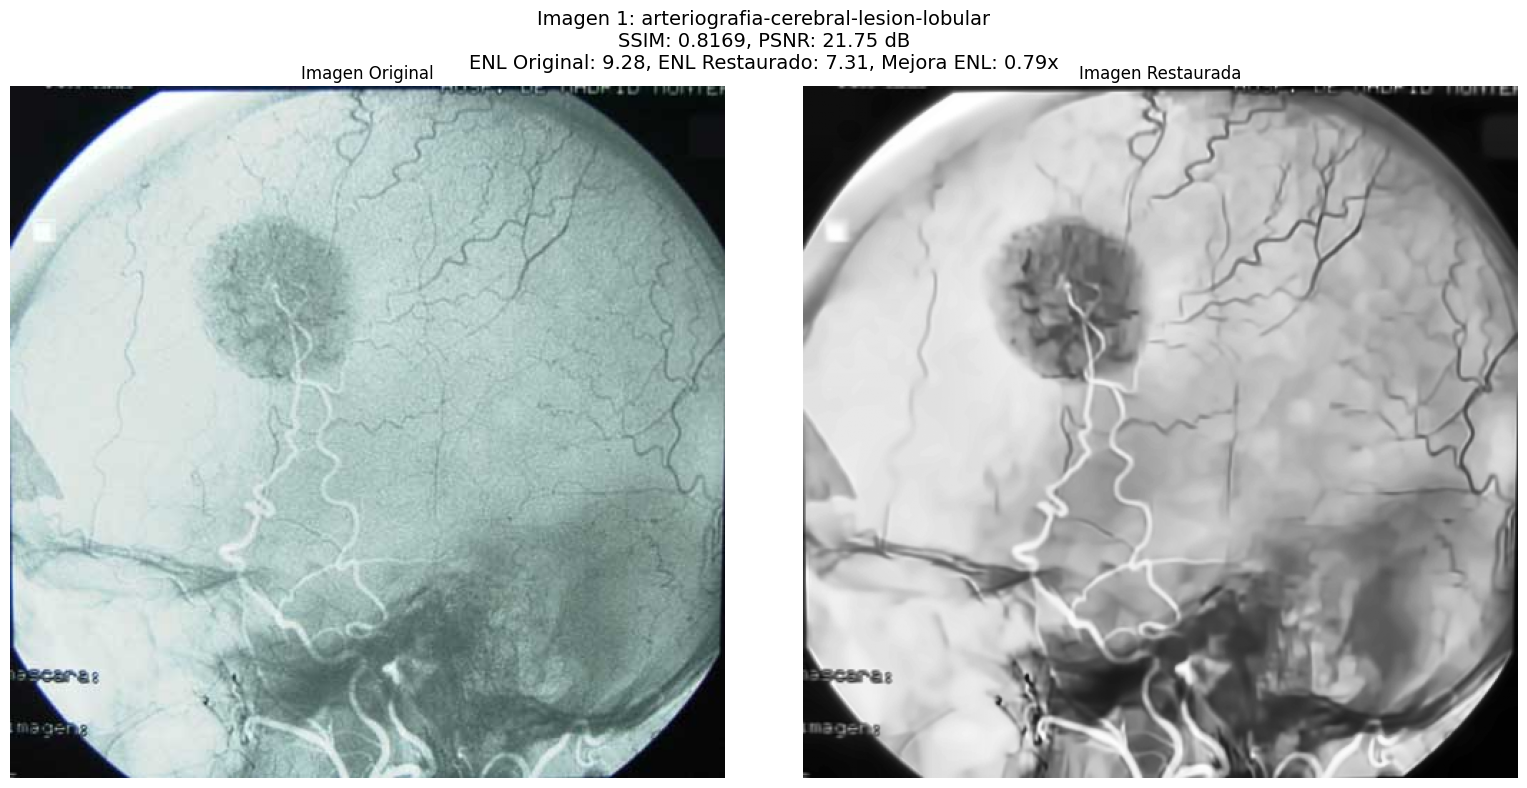


Analizando regiones de interés para detectar artefactos o pérdida de detalles...


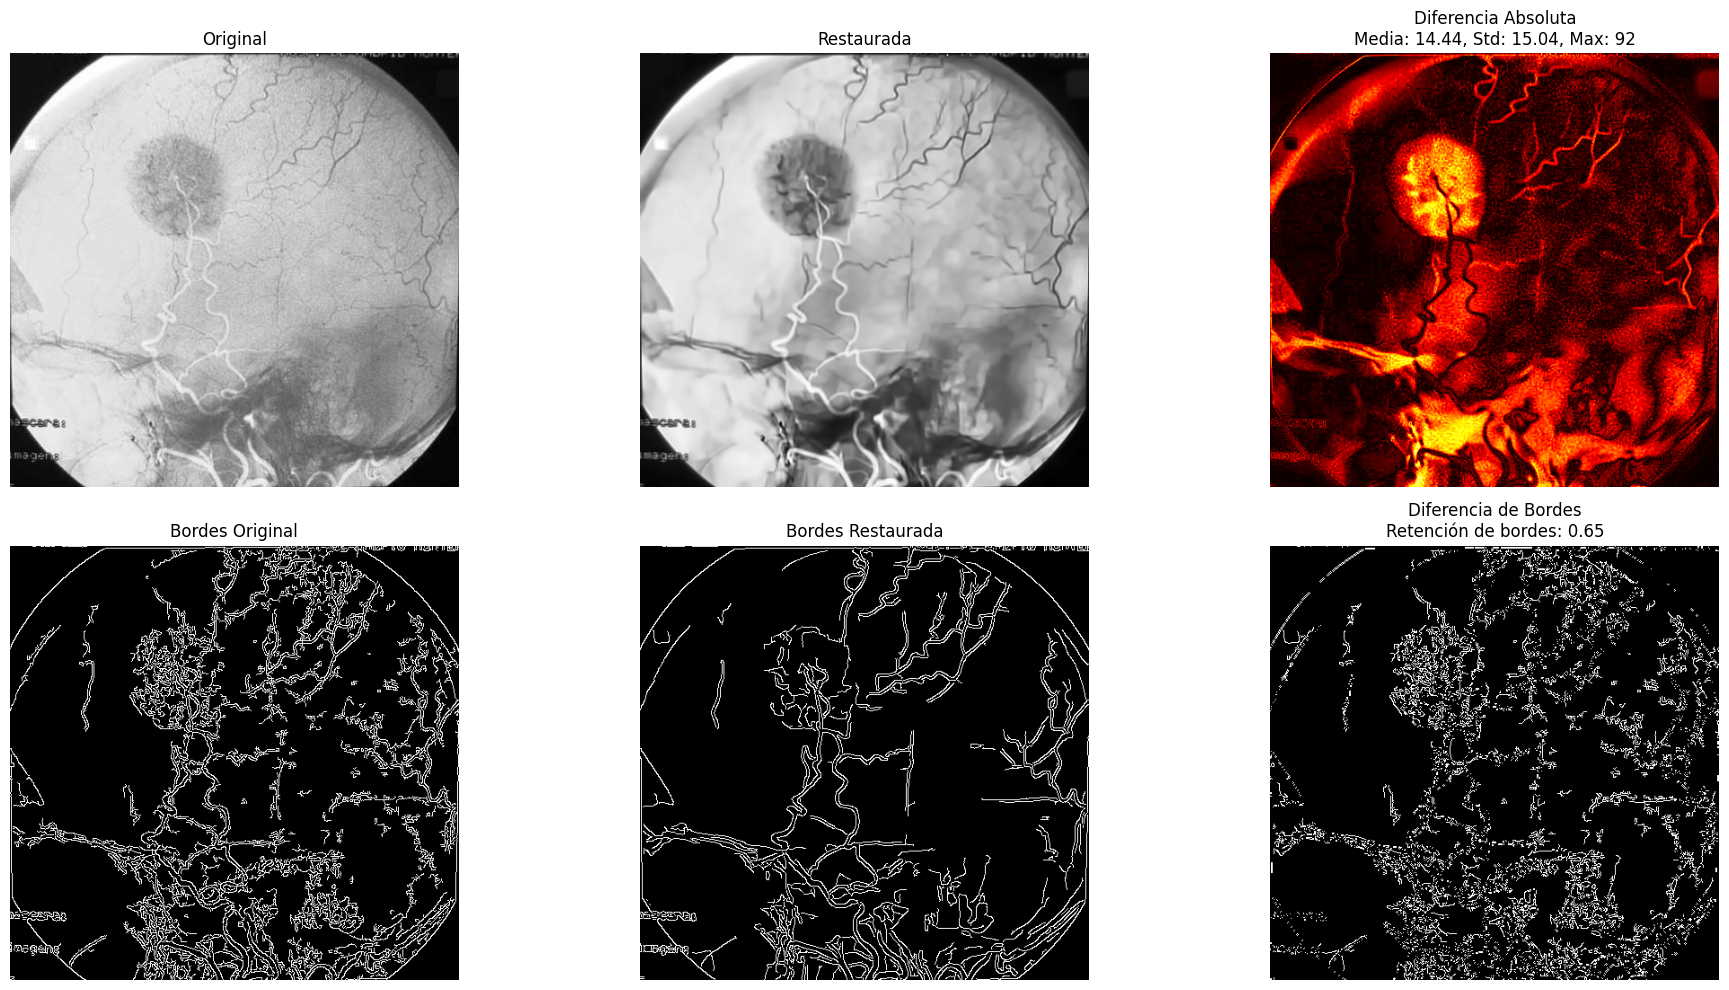

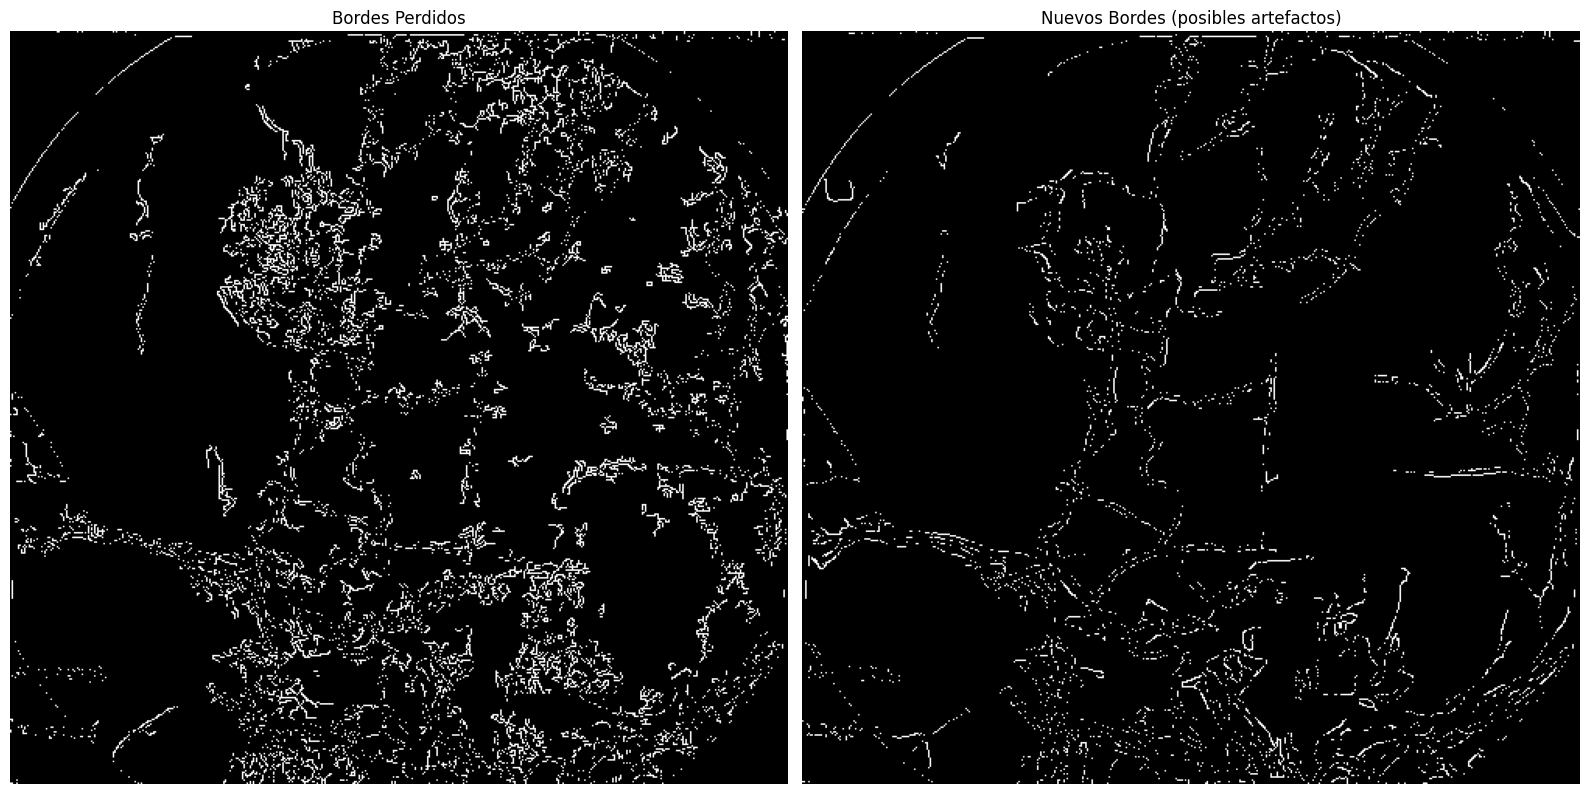


Procesando imagen 2/4: rm-cerebral-tumor-zona-necrotica.jpg
No se pudo usar SwinIR: cannot access local variable 'device' where it is not associated with a value
Usando método alternativo de restauración...
Imagen restaurada con BM3D.


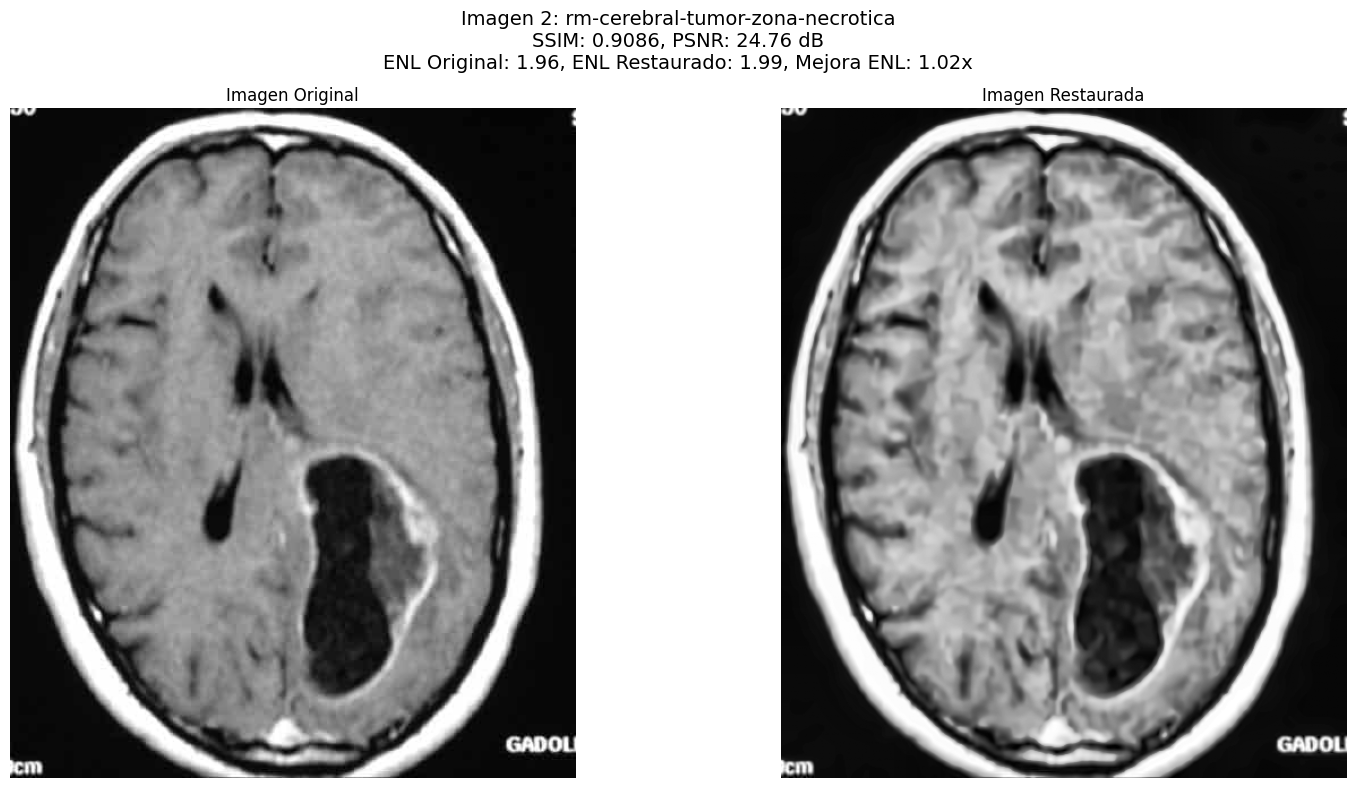


Analizando regiones de interés para detectar artefactos o pérdida de detalles...


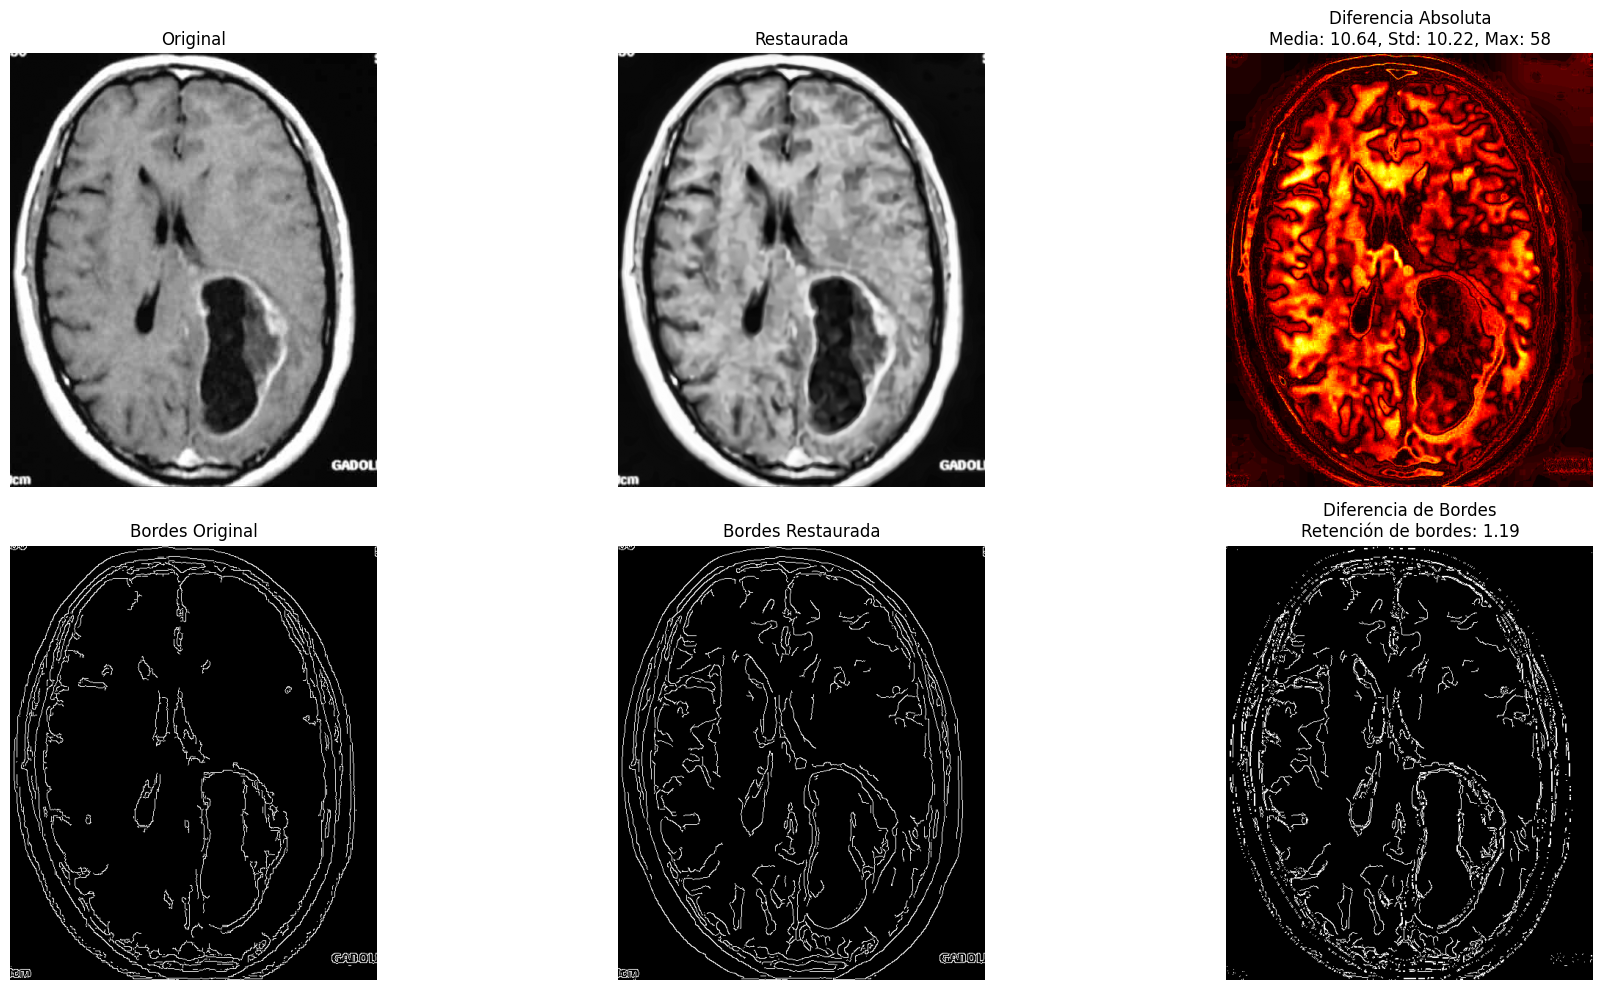

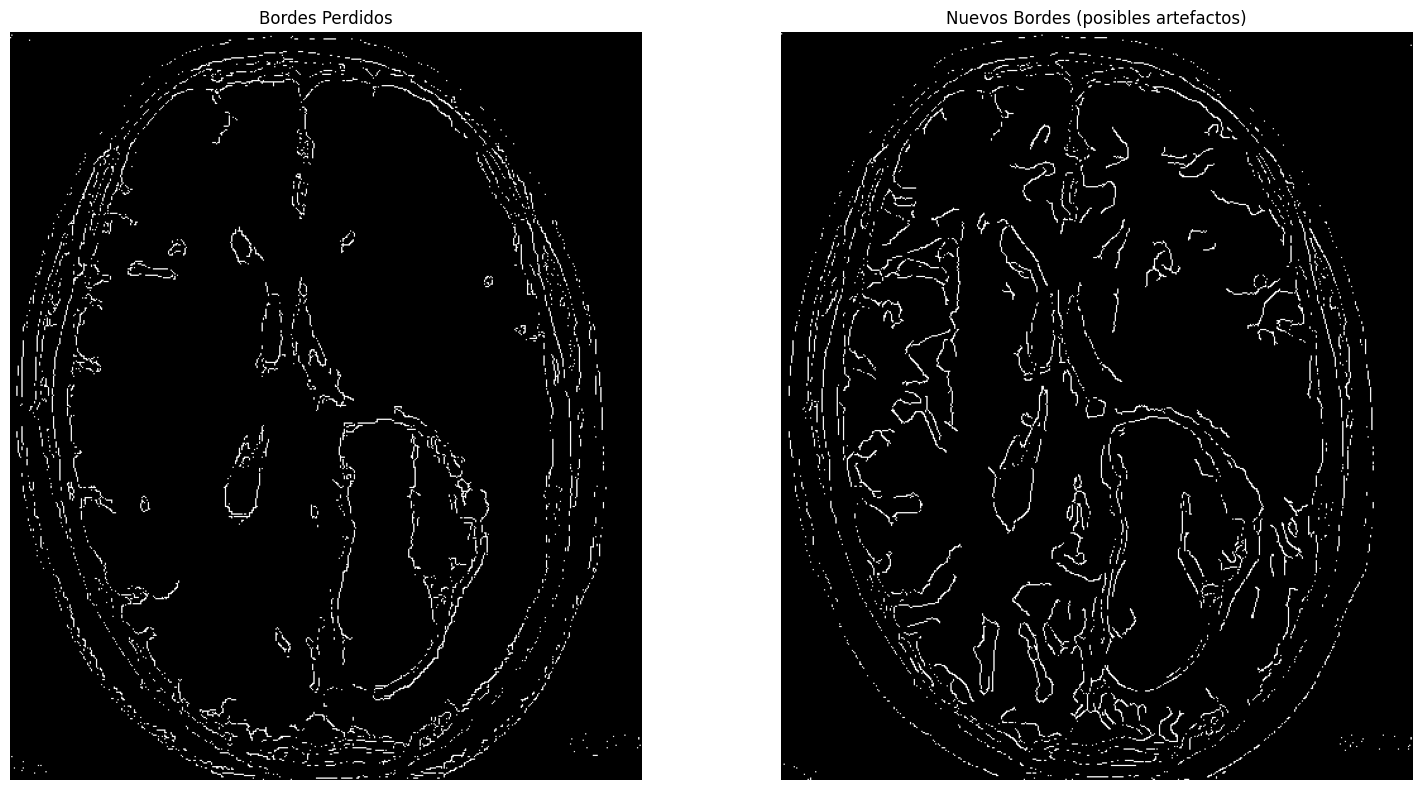


Procesando imagen 3/4: rm-funcional-paciente-tumor.jpg
No se pudo usar SwinIR: cannot access local variable 'device' where it is not associated with a value
Usando método alternativo de restauración...
Imagen restaurada con BM3D.


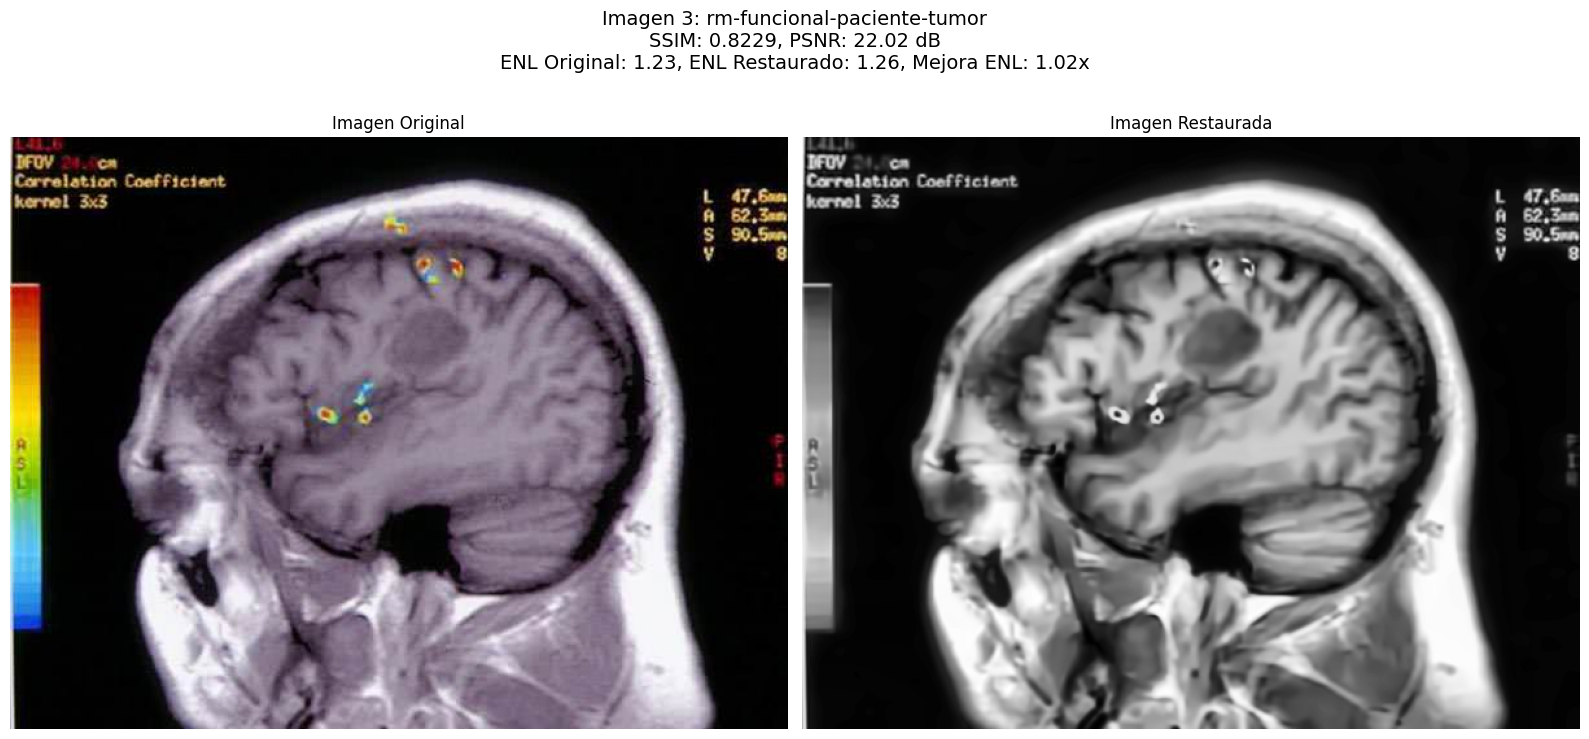


Analizando regiones de interés para detectar artefactos o pérdida de detalles...


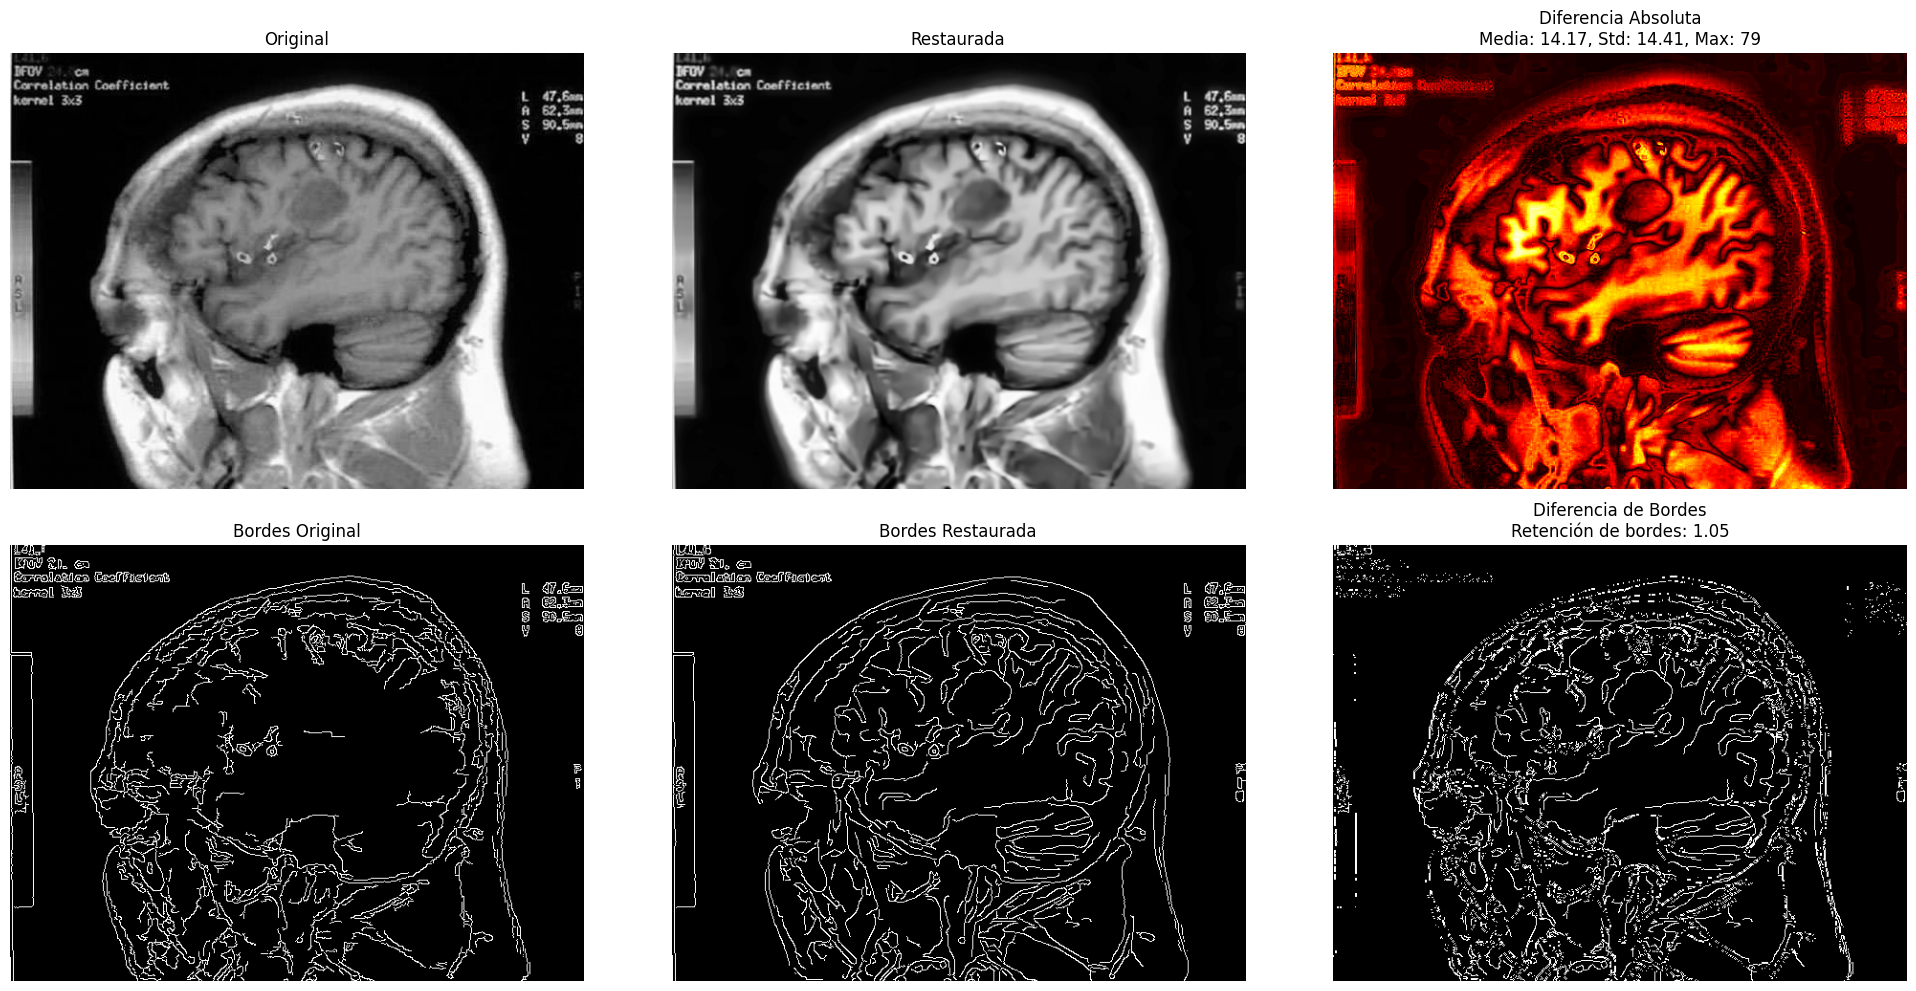

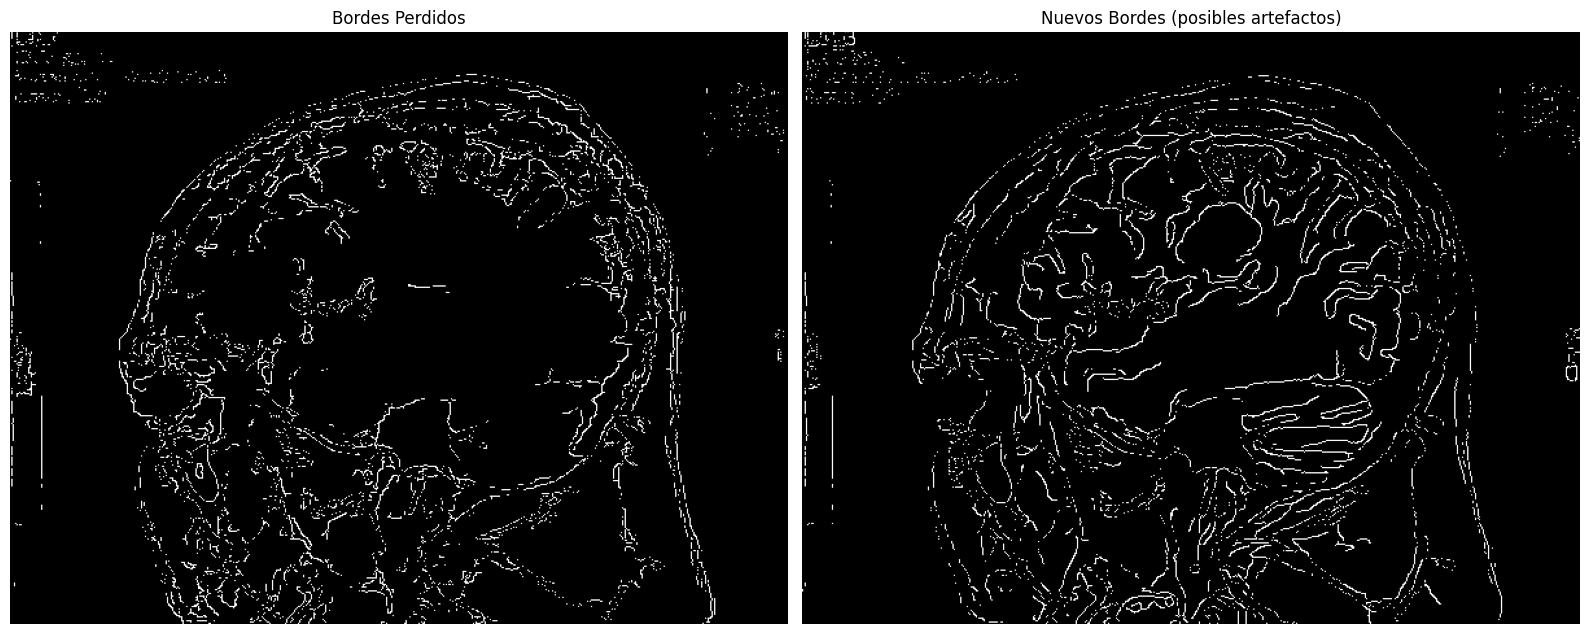


Procesando imagen 4/4: tac-craneal-con-tumor.jpg
No se pudo usar SwinIR: cannot access local variable 'device' where it is not associated with a value
Usando método alternativo de restauración...
Imagen restaurada con BM3D.


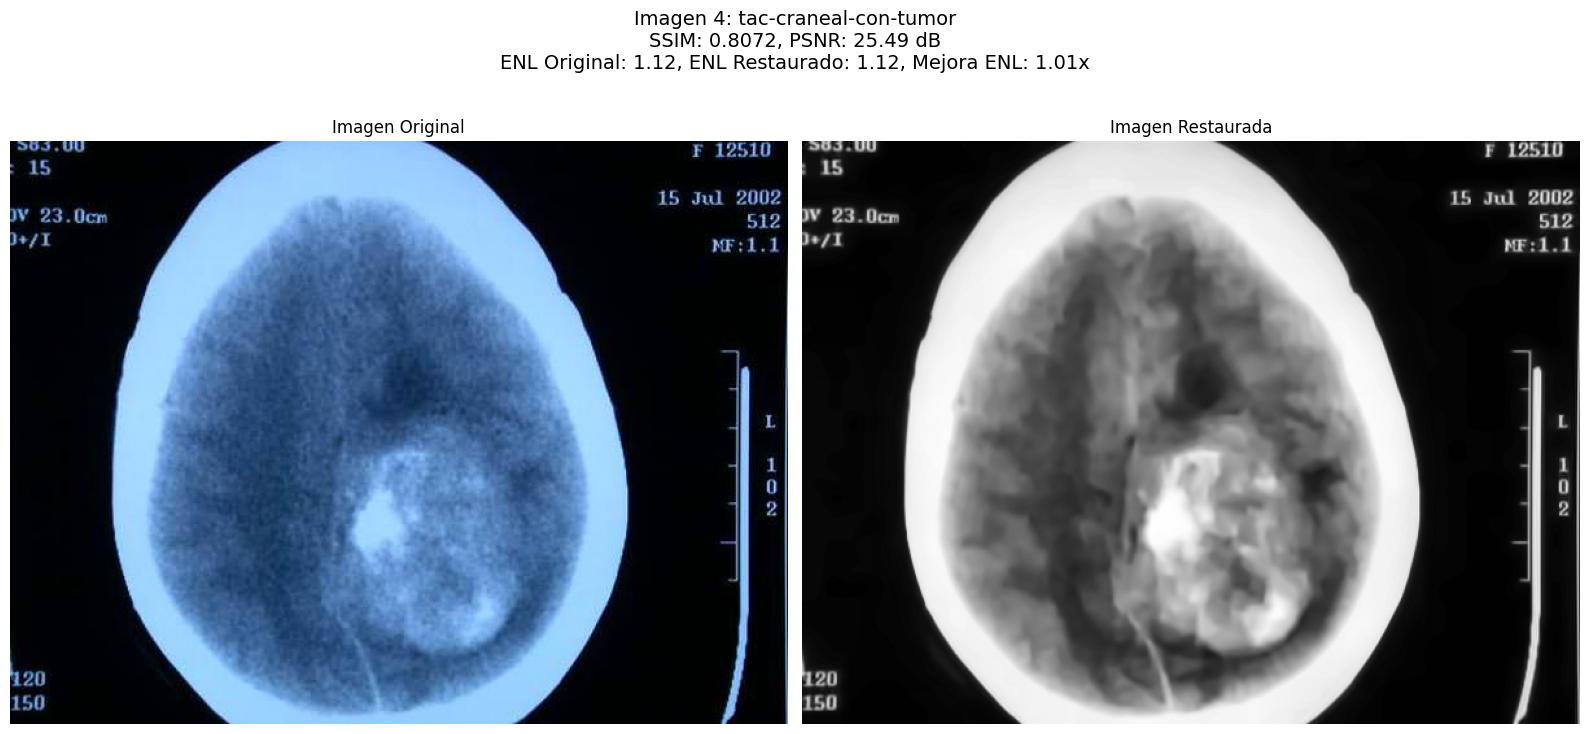


Analizando regiones de interés para detectar artefactos o pérdida de detalles...


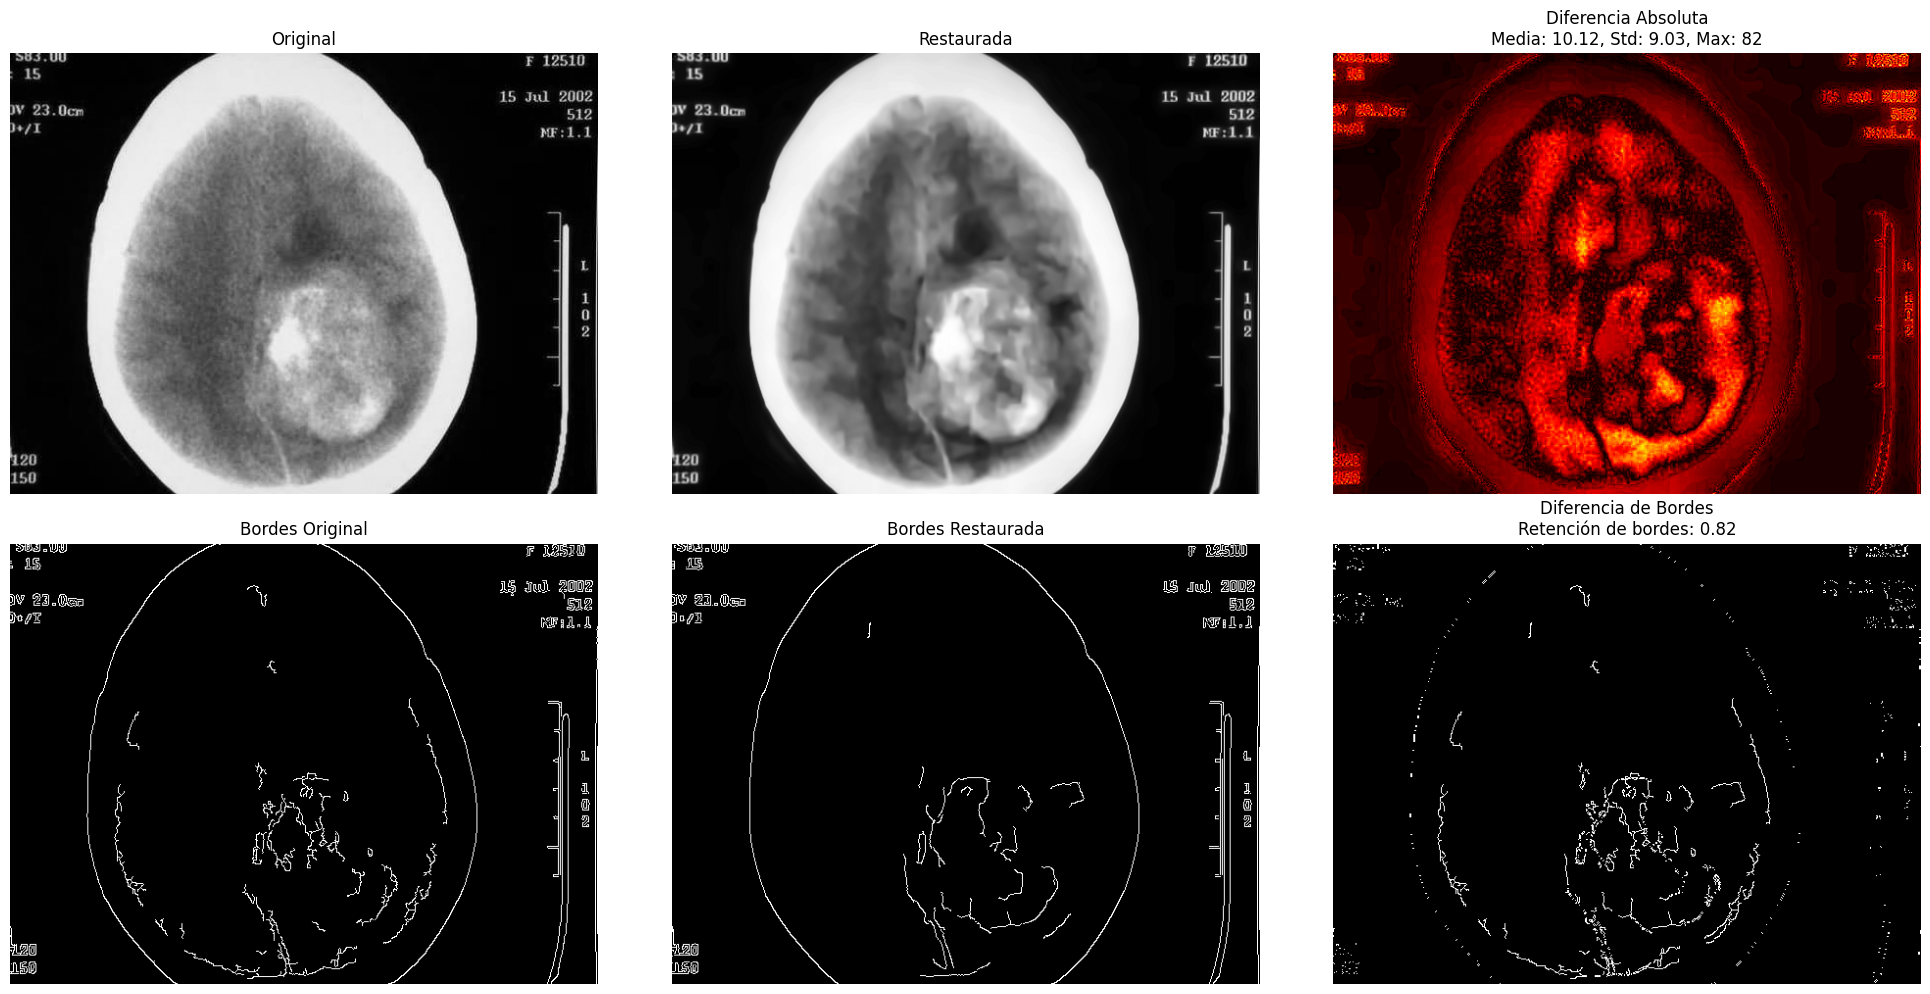

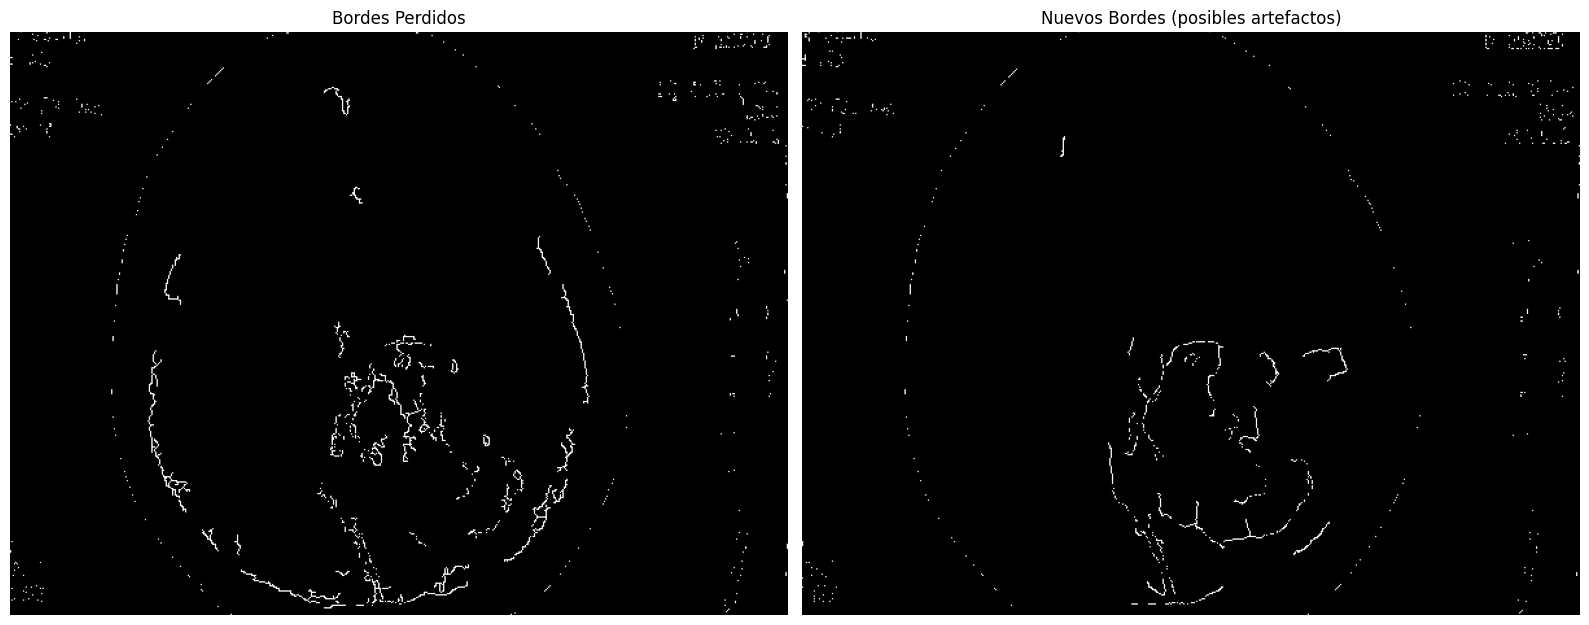


===== Resumen de Resultados =====
Total de imágenes procesadas: 4
SSIM promedio: 0.8389
PSNR promedio: 23.50 dB
Mejora ENL promedio: 0.96x

Resultados guardados en: /content/drive/MyDrive/VISION_con_IA/G_4_Apre_prof/Img_TAC/resultados/resultados_metricas.csv
Imágenes y comparaciones guardadas en: /content/drive/MyDrive/VISION_con_IA/G_4_Apre_prof/Img_TAC/resultados


In [ ]:
# Función modificada para aplicar SwinIR con manejo de errores mejorado
def apply_restoration(img):
    """
    Aplica un modelo de restauración a la imagen.
    Si SwinIR no está disponible, usamos otro método.
    """
    try:
        # Intentamos usar SwinIR si está disponible
        if 'swinir' not in globals():
            print("Instalando SwinIR y dependencias...")
            !pip install -q timm
            !git clone https://github.com/JingyunLiang/SwinIR.git

            import sys
            sys.path.append('./SwinIR')

            # Modificación: Importar correctamente las funciones de SwinIR
            from utils import util_calculate_psnr_ssim as util
            import models.network_swinir as network

            global swinir
            swinir = True

            # Descargamos un modelo preentrenado para restauración de imágenes médicas
            !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P ./SwinIR/experiments/pretrained_models

            # Definimos el modelo - Corregido para usar la API actual
            model_path = './SwinIR/experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth'
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            # Creamos el modelo usando la API correcta de SwinIR
            model = network.SwinIR(upscale=1, in_chans=3, img_size=64, window_size=8,
                                 img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180,
                                 num_heads=[6, 6, 6, 6, 6, 6], mlp_ratio=2, upsampler='')

            # Cargamos los pesos del modelo
            pretrained_model = torch.load(model_path)
            param_key_g = 'params_ema' if 'params_ema' in pretrained_model else 'params'
            model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model else pretrained_model, strict=True)
            model.eval()
            model = model.to(device)

        # Convertimos la imagen a PIL y luego a tensor
        img_pil = Image.fromarray(np.uint8(img))
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img_pil).unsqueeze(0).to(device)

        # Asegurarse de que la imagen tenga 3 canales para SwinIR
        if img_tensor.shape[1] == 1:
            img_tensor = img_tensor.repeat(1, 3, 1, 1)

        with torch.no_grad():
            output = model(img_tensor)

        # Convertimos de tensor a numpy
        output = output.squeeze().float().cpu().clamp_(0, 1).numpy()
        output = np.transpose(output, (1, 2, 0))
        if output.shape[2] == 3 and len(img.shape) == 2:  # Si la imagen original era escala de grises
            output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)

        restored_img = np.uint8(output * 255.0)

        print("Imagen restaurada con SwinIR.")
        return restored_img

    except Exception as e:
        print(f"No se pudo usar SwinIR: {e}")
        print("Usando método alternativo de restauración...")

        # Método alternativo: BM3D o filtros clásicos
        try:
            # Intentamos usar BM3D
            !pip install -q bm3d
            import bm3d

            # Convertimos a escala de grises si es necesario
            if len(img.shape) > 2 and img.shape[2] > 1:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img.copy()

            # Estimamos el nivel de ruido
            sigma_est = np.mean(estimate_noise(gray))
            sigma_est = max(5, min(sigma_est, 75))  # Limitamos entre 5 y 75

            # Aplicamos BM3D
            denoised = bm3d.bm3d(gray, sigma_psd=sigma_est)
            restored_img = np.uint8(np.clip(denoised, 0, 255))

            # Mejoramos el contraste
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            restored_img = clahe.apply(restored_img)

            print("Imagen restaurada con BM3D.")
            return restored_img

        except Exception as e:
            print(f"No se pudo usar BM3D: {e}")
            print("Usando métodos clásicos de OpenCV...")

            # Si BM3D falla, usamos filtros clásicos
            # Convertimos a escala de grises si es necesario
            if len(img.shape) > 2 and img.shape[2] > 1:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img.copy()

            # Usamos un filtro de reducción de ruido
            restored_img = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

            # Mejoramos el contraste
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            restored_img = clahe.apply(restored_img)

            print("Imagen restaurada con métodos clásicos de OpenCV.")
            return restored_img

# Función para evaluar las métricas entre la imagen original y la restaurada
def evaluate_metrics(original, restored):
    """
    Calcula las métricas de calidad entre la imagen original y la restaurada.
    """
    # Convertimos a escala de grises si es necesario
    if len(original.shape) > 2 and original.shape[2] > 1:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original

    if len(restored.shape) > 2 and restored.shape[2] > 1:
        restored_gray = cv2.cvtColor(restored, cv2.COLOR_BGR2GRAY)
    else:
        restored_gray = restored

    # Aseguramos que las imágenes tengan el mismo tamaño
    if original_gray.shape != restored_gray.shape:
        restored_gray = cv2.resize(restored_gray, (original_gray.shape[1], original_gray.shape[0]))

    # Calculamos las métricas
    ssim_value = ssim(original_gray, restored_gray)
    psnr_value = psnr(original_gray, restored_gray)
    enl_original = calculate_enl(original_gray)
    enl_restored = calculate_enl(restored_gray)

    return {
        'SSIM': ssim_value,
        'PSNR': psnr_value,
        'ENL_original': enl_original,
        'ENL_restored': enl_restored,
        'ENL_improvement': enl_restored / enl_original if enl_original > 0 else float('inf')
    }

# Función para visualizar los resultados
def visualize_results(original, restored, metrics, title, save_path=None):
    """
    Visualiza la imagen original y restaurada, junto con las métricas.
    """
    plt.figure(figsize=(16, 8))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    # Imagen restaurada
    plt.subplot(1, 2, 2)
    plt.imshow(restored, cmap='gray')
    plt.title('Imagen Restaurada')
    plt.axis('off')

    # Mostramos las métricas
    plt.suptitle(f"{title}\nSSIM: {metrics['SSIM']:.4f}, PSNR: {metrics['PSNR']:.2f} dB\n"
                f"ENL Original: {metrics['ENL_original']:.2f}, ENL Restaurado: {metrics['ENL_restored']:.2f}, "
                f"Mejora ENL: {metrics['ENL_improvement']:.2f}x", fontsize=14)

    plt.tight_layout()

    # Guardamos la figura si se proporciona una ruta
    if save_path:
        plt.savefig(save_path)

    plt.show()

# Función para analizar regiones de interés (ROI) para detectar artefactos o pérdida de detalles
def analyze_roi(original, restored):
    """
    Analiza regiones de interés para detectar artefactos o pérdida de detalles.
    """
    # Calculamos la diferencia absoluta entre la imagen original y la restaurada
    if len(original.shape) > 2 and original.shape[2] > 1:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original

    if len(restored.shape) > 2 and restored.shape[2] > 1:
        restored_gray = cv2.cvtColor(restored, cv2.COLOR_BGR2GRAY)
    else:
        restored_gray = restored

    # Aseguramos que las imágenes tengan el mismo tamaño
    if original_gray.shape != restored_gray.shape:
        restored_gray = cv2.resize(restored_gray, (original_gray.shape[1], original_gray.shape[0]))

    # Calculamos la diferencia absoluta
    diff = cv2.absdiff(original_gray, restored_gray)

    # Definimos un umbral para detectar cambios significativos
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Calculamos estadísticas de la diferencia
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    max_diff = np.max(diff)

    # Calcular bordes en ambas imágenes para detectar pérdida de detalles
    edges_original = cv2.Canny(original_gray, 50, 150)
    edges_restored = cv2.Canny(restored_gray, 50, 150)

    # Diferencia en los bordes (pérdida o adición de detalles)
    edges_diff = cv2.absdiff(edges_original, edges_restored)
    lost_edges = cv2.bitwise_and(edges_original, cv2.bitwise_not(edges_restored))
    new_edges = cv2.bitwise_and(edges_restored, cv2.bitwise_not(edges_original))

    # Estadísticas de bordes
    edge_retention = np.sum(edges_restored) / np.sum(edges_original) if np.sum(edges_original) > 0 else float('inf')

    # Visualizamos los resultados
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(original_gray, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(restored_gray, cmap='gray')
    plt.title('Restaurada')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(diff, cmap='hot')
    plt.title(f'Diferencia Absoluta\nMedia: {mean_diff:.2f}, Std: {std_diff:.2f}, Max: {max_diff}')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(edges_original, cmap='gray')
    plt.title('Bordes Original')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges_restored, cmap='gray')
    plt.title('Bordes Restaurada')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(edges_diff, cmap='gray')
    plt.title(f'Diferencia de Bordes\nRetención de bordes: {edge_retention:.2f}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Visualizamos los detalles perdidos/añadidos
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(lost_edges, cmap='gray')
    plt.title('Bordes Perdidos')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(new_edges, cmap='gray')
    plt.title('Nuevos Bordes (posibles artefactos)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'max_diff': max_diff,
        'edge_retention': edge_retention,
        'lost_edges_ratio': np.sum(lost_edges) / np.sum(edges_original) if np.sum(edges_original) > 0 else 0,
        'new_edges_ratio': np.sum(new_edges) / np.sum(edges_original) if np.sum(edges_original) > 0 else float('inf')
    }

# Función principal
def main():
    # Almacenamos los resultados para cada imagen
    results = []

    # Procesamos cada imagen
    for i, img_file in enumerate(img_files):
        print(f"\nProcesando imagen {i+1}/{len(img_files)}: {os.path.basename(img_file)}")

        # Cargamos la imagen
        img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"Error al cargar la imagen {img_file}")
            continue

        # Convertimos BGR a RGB si es necesario
        if len(img.shape) > 2 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Aplicamos la restauración
        restored_img = apply_restoration(img)

        # Calculamos las métricas
        metrics = evaluate_metrics(img, restored_img)

        # Guardamos la imagen restaurada
        base_name = os.path.splitext(os.path.basename(img_file))[0]
        restored_path = os.path.join(output_path, f"{base_name}_restored.png")
        cv2.imwrite(restored_path, restored_img if len(restored_img.shape) <= 2 or restored_img.shape[2] == 1
                    else cv2.cvtColor(restored_img, cv2.COLOR_RGB2BGR))

        # Visualizamos los resultados
        visualize_path = os.path.join(output_path, f"{base_name}_comparison.png")
        visualize_results(img, restored_img, metrics, f"Imagen {i+1}: {base_name}", visualize_path)

        # Analizamos las regiones de interés
        print("\nAnalizando regiones de interés para detectar artefactos o pérdida de detalles...")
        roi_metrics = analyze_roi(img, restored_img)

        # Almacenamos los resultados
        results.append({
            'filename': os.path.basename(img_file),
            'metrics': metrics,
            'roi_metrics': roi_metrics
        })

    # Mostramos un resumen de los resultados
    print("\n===== Resumen de Resultados =====")
    print(f"Total de imágenes procesadas: {len(results)}")

    # Calculamos promedios
    avg_ssim = np.mean([r['metrics']['SSIM'] for r in results])
    avg_psnr = np.mean([r['metrics']['PSNR'] for r in results])
    avg_enl_imp = np.mean([r['metrics']['ENL_improvement'] for r in results
                          if not np.isinf(r['metrics']['ENL_improvement'])])

    print(f"SSIM promedio: {avg_ssim:.4f}")
    print(f"PSNR promedio: {avg_psnr:.2f} dB")
    print(f"Mejora ENL promedio: {avg_enl_imp:.2f}x")

    # Guardamos los resultados en un archivo CSV
    csv_path = os.path.join(output_path, "resultados_metricas.csv")
    with open(csv_path, 'w') as f:
        f.write("Archivo,SSIM,PSNR,ENL_Original,ENL_Restaurado,Mejora_ENL,Retención_Bordes,Bordes_Perdidos,Nuevos_Bordes\n")
        for r in results:
            m = r['metrics']
            roi = r['roi_metrics']
            f.write(f"{r['filename']},{m['SSIM']:.4f},{m['PSNR']:.2f},{m['ENL_original']:.2f},"
                   f"{m['ENL_restored']:.2f},{m['ENL_improvement']:.2f},{roi['edge_retention']:.2f},"
                   f"{roi['lost_edges_ratio']:.4f},{roi['new_edges_ratio']:.4f}\n")

    print(f"\nResultados guardados en: {csv_path}")
    print(f"Imágenes y comparaciones guardadas en: {output_path}")

# Ejecutamos el programa principal
if __name__ == "__main__":
    main()